In [1]:
## M1 100%

import pandas as pd 
import numpy as np
import os
ress2 = pd.read_csv('M1bands3_M1all_prediction_sub512_2048_#layers2_emb512_s2_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })
resl8 = pd.read_csv('M1bands3_M1all_prediction_sub512_2048_#layers2_emb32_l8_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })

ress2['h_geocode'] = ress2['h_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)
ress2['w_geocode'] = ress2['w_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)
resl8['h_geocode'] = resl8['h_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)
resl8['w_geocode'] = resl8['w_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)

population = pd.read_csv("/data/Population_us/DECENNIALDHC2020.P1-Data.csv", header=1)
population = population.rename(columns={' !!Total': 'population'})
population['geoid'] = population['Geography'].apply(lambda x:str(x)[-11:])
# res.set_index(['h_geocode','w_geocode'])
res_total = pd.concat([
        #    res.set_index(['h_geocode','w_geocode']),
           ress2.set_index(['h_geocode','w_geocode']),
           resl8.set_index(['h_geocode','w_geocode'])]
           , axis=1, join="inner")
res_total.drop(columns='Unnamed: 0', inplace=True)
# res_total.columns = ['count', 'prediction_r1w', 'c', 'prediction_s2', 'c', 'prediction_l8']
res_total.columns = ['count', 'prediction_s2', 'c', 'prediction_l8']
# res_total.rename(columns={res_total.columns[1]: "prediction_r1w", res_total.columns[3]: "prediction_s2", res_total.columns[5]: "prediction_l8"}
#                 )
res_total.drop(columns='c'
               ,inplace=True)
res_total = res_total.reset_index()
res_total

,h_geocode,w_geocode,count,prediction_s2,prediction_l8
0,34003010100,34003001001,17.0,28.889042,15.782871
1,34003039200,34003001001,14.0,28.309130,23.440170
2,34003053202,34003001001,12.0,28.240685,21.065716
3,34031256801,34003001001,11.0,25.285242,18.195793
4,36087011303,34003001001,12.0,29.730057,22.789635
...,...,...,...,...,...
120554,42103950606,42103950603,156.0,22.897455,20.939974
120555,42103950606,42103950606,50.0,23.322773,21.678310
120556,42103950606,42103950607,34.0,22.725319,20.389482
120557,42103950606,42103950702,30.0,22.680368,18.899055


# LU

In [2]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

shapefile_path = 'data/Landuse/Tabulat_LU_M1.dbf' # 2327
lu = gpd.read_file(shapefile_path)

In [3]:
lu = pd.DataFrame(lu)
lu = lu.set_index('GEOID20')
lu = lu.drop(columns='geometry')
lu['max_class'] = lu.idxmax(axis=1)

In [4]:
lu['max_class'].value_counts()

VALUE_6    2871
VALUE_5    1358
VALUE_2     463
VALUE_3      91
VALUE_4      13
Name: max_class, dtype: int64

In [5]:
for i in res_total['h_geocode'].unique():
    try:
        res_total.loc[res_total['h_geocode']==i, 'LU'] = lu.loc[str(i)]['max_class']
    except KeyError:
        res_total.loc[res_total['h_geocode']==i, 'LU'] = 'UNKNOWN'
   

In [6]:
# 2 * np.minimum(res['count'], res['prediction']).sum() / (res['count'].sum() + res['prediction'].sum()) 
def CPC(y_hat, y):
    '''
    Common Part of Commuters Metric
    '''
    return 2 * np.minimum(y_hat, y).sum() / (y_hat.sum() + y.sum()) 

In [7]:
  # Theme '1': Agriculture
  # Theme '2': Commercial
  # Theme '3': Industrial
  # Theme '4': Recreational
  # Theme '5': Residential-Income
  # Theme '6': Residential-Owned
table = pd.DataFrame(columns=['LU','count',
                              # 'CPC r1w',
                              'CPC s2','CPC l8'])
for i in res_total['LU'].unique():
    df = res_total[res_total['LU']==i]
    print(i, len(df)
      #     ,CPC(df['count'], df['prediction_r1w'])
          ,CPC(df['count'], df['prediction_s2'])
          ,CPC(df['count'], df['prediction_l8']))
    table = table.append({'LU':i,
               'count':len(df),
            #    'CPC r1w':CPC(df['count'], df['prediction_r1w']),
               'CPC s2':CPC(df['count'], df['prediction_s2']),
               'CPC l8':CPC(df['count'], df['prediction_l8'])}
               ,ignore_index=True)

table

VALUE_6 79019 0.7475802987148529 0.7424404224415859
VALUE_2 11924 0.761930999512687 0.7582401765614001
VALUE_5 24441 0.7770847740251342 0.7699483598347597
VALUE_3 927 0.778783469847713 0.7777897897687279
UNKNOWN 3988 0.7483991988811771 0.7434957295627674
VALUE_4 260 0.6604602662452178 0.6528472187765271


,LU,count,CPC s2,CPC l8
0,VALUE_6,79019,0.747580,0.742440
1,VALUE_2,11924,0.761931,0.758240
2,VALUE_5,24441,0.777085,0.769948
3,VALUE_3,927,0.778783,0.777790
4,UNKNOWN,3988,0.748399,0.743496
5,VALUE_4,260,0.660460,0.652847


In [8]:
# res_total['common_r1w'] = res_total[['prediction_r1w','count']].min(axis=1)
res_total['common_s2'] = res_total[['prediction_s2','count']].min(axis=1)
res_total['common_l8'] = res_total[['prediction_l8','count']].min(axis=1)

In [9]:
home_sum = res_total.groupby('h_geocode').sum()
for index, row in home_sum.iterrows():
    try:
        home_sum.at[index, 'LU'] = lu.loc[str(index)]['max_class']
    except KeyError:
        home_sum.at[index, 'LU'] = 'UNKNOWN'
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
home_sum['h_cpc_s2'] = 2 * home_sum['common_s2'] / (home_sum['count']+home_sum['prediction_s2'])
home_sum['h_cpc_l8'] = 2 * home_sum['common_l8'] / (home_sum['count']+home_sum['prediction_l8'])
home_sum

,count,prediction_s2,prediction_l8,common_s2,common_l8,LU,h_cpc_s2,h_cpc_l8
h_geocode,,,,,,,,
34003001001,313.0,420.102094,362.207821,288.880361,270.170654,VALUE_6,0.788104,0.800259
34003001002,372.0,492.744597,514.673746,315.453657,314.437721,VALUE_6,0.729588,0.709252
34003002100,92.0,110.276234,89.213580,86.382560,76.519951,VALUE_6,0.854105,0.844528
34003002200,762.0,674.992714,695.620395,487.190960,493.107146,VALUE_6,0.678070,0.676592
34003002300,843.0,795.540028,721.470892,581.597144,560.800573,VALUE_6,0.709897,0.716920
...,...,...,...,...,...,...,...,...
42103950804,97.0,86.680024,89.045233,71.187941,71.431643,UNKNOWN,0.775130,0.767895
42103950805,43.0,23.254513,22.453606,23.254513,22.453606,VALUE_6,0.701975,0.686092
42103950806,68.0,44.484017,24.486654,43.020245,24.486654,UNKNOWN,0.764913,0.529518


In [10]:
home_sum2 = home_sum
home_sum2['LU'] = home_sum2['LU'].apply(lambda x: 'VALUE_5' if x=='VALUE_6' else x)

    decile count  CPC s2 mean  CPC l8 mean
0  VALUE_2   440     0.767204     0.762158
1  VALUE_3    68     0.759700     0.759936
2  VALUE_4     7     0.732251     0.727495
3  VALUE_5  4128     0.761760     0.756343


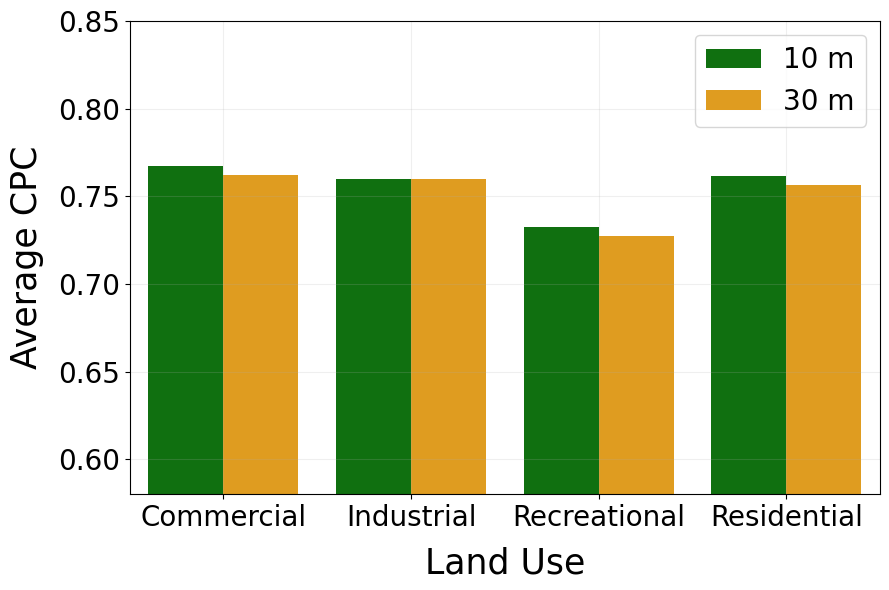

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns


column_name = 'LU'
axisx_label = 'Land Use'
# x_ticklabels = ['built up', 'forest','cultivated', 'wetlands', 'water', 'open space']
x_ticklabels = [ 'Commercial','Industrial', 'Recreational', 'Residential']
df = home_sum2
x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

# st = fig.suptitle(country_to_string[country], fontsize=30)

# avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
# std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []

table = pd.DataFrame(columns=['decile','count',
                            #   'CPC r1w mean',
                                'CPC s2 mean','CPC l8 mean'])
# for decile in sorted(df[column_name].unique()):
for decile in ['VALUE_2', 'VALUE_3', 'VALUE_4', 'VALUE_5']:
    df_temp = df[df[column_name] == decile]

    # avg_r1w = df_temp.h_cpc_r1w.mean()
    avg_s2 = df_temp.h_cpc_s2.mean()
    avg_l8 = df_temp.h_cpc_l8.mean()
    

    # avg_r1ws.append(avg_r1w)
    avg_s2s.append(avg_s2)
    avg_l8s.append(avg_l8)

    # std_r1w = df_temp.h_cpc_r1w.std()
    std_s2 = df_temp.h_cpc_s2.std()
    std_l8 = df_temp.h_cpc_l8.std()

    # std_r1ws.append(std_r1w)
    std_s2s.append(std_s2)
    std_l8s.append(std_l8)

    table = table.append({'decile':decile,
                'count':len(df_temp),
            #    'CPC r1w mean':avg_r1w,
                'CPC s2 mean':avg_s2,
                'CPC l8 mean':avg_l8}
                ,ignore_index=True)

print(table)
table_s2 = table[['decile', 'count', 'CPC s2 mean']].rename(columns={'CPC s2 mean':'mean_cpc'})
table_s2['resolution'] = '10 m'
table_l8 = table[['decile', 'count', 'CPC l8 mean']].rename(columns={'CPC l8 mean':'mean_cpc'})
table_l8['resolution'] = '30 m'
table_2 = pd.concat([table_s2, table_l8])

sns.barplot(table_2, x="decile", y="mean_cpc", hue="resolution", palette=['green', 'orange'])

# ax.bar(range(x_ticks), avg_s2s, 
#         color='green', label='10 m')  

# ax.bar(range(x_ticks), avg_l8s, 
#         color='orange', label='30 m')  


# ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
#           color='darkgrey', linewidth=2, 
#           label='MFG', markersize=8)

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0.58,0.85)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='upper right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig('./figs/M1_LU.png')

In [13]:
table_s2 = table[['decile', 'count', 'CPC s2 mean']].rename(columns={'CPC s2 mean':'mean_cpc'})
table_s2['resolution'] = 's2'
table_l8 = table[['decile', 'count', 'CPC l8 mean']].rename(columns={'CPC l8 mean':'mean_cpc'})
table_l8['resolution'] = 'l8'

In [17]:
sorted(home_sum.LU.unique())

['UNKNOWN', 'VALUE_2', 'VALUE_3', 'VALUE_4', 'VALUE_5', 'VALUE_6']

In [16]:
# Land Cover
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

shapefile_path = 'data/Landuse/Tabulat_value_M1.dbf' 
gdf_lu = gpd.read_file(shapefile_path)
gdf_lu = gdf_lu.set_index('GEOID20')
gdf_lu = gdf_lu.drop(columns='geometry')

gdf_lu['SUM_22_23_24'] = gdf_lu['VALUE_22'] + gdf_lu['VALUE_23'] + gdf_lu['VALUE_24']
gdf_lu['SUM_4'] = gdf_lu['VALUE_41'] + gdf_lu['VALUE_42'] + gdf_lu['VALUE_43']
gdf_lu['SUM_8'] = gdf_lu['VALUE_81'] + gdf_lu['VALUE_82']
gdf_lu['SUM_9'] = gdf_lu['VALUE_90'] + gdf_lu['VALUE_95']
print(gdf_lu[['VALUE_0', 'VALUE_11', 'VALUE_21', 'SUM_22_23_24', 'VALUE_31', 'SUM_4', 'VALUE_52', 'VALUE_71', 'SUM_8', 'SUM_9']].sum())

gdf_lu = gdf_lu[['VALUE_0', 'VALUE_11', 'VALUE_21', 'SUM_22_23_24', 'VALUE_31', 'SUM_4', 'VALUE_52', 'VALUE_71', 'SUM_8', 'SUM_9']]
gdf_lu['max_class'] = gdf_lu.idxmax(axis=1)

VALUE_0         1.442700e+06
VALUE_11        6.424606e+09
VALUE_21        2.593972e+09
SUM_22_23_24    5.240250e+09
VALUE_31        1.408410e+08
SUM_4           6.135656e+09
VALUE_52        7.646220e+07
VALUE_71        1.187406e+08
SUM_8           1.195045e+09
SUM_9           1.931636e+09
dtype: float64


In [17]:
for i in res_total['h_geocode'].unique():
    try:
        res_total.loc[res_total['h_geocode']==i, 'LC'] = gdf_lu.loc[str(i)]['max_class']
    except KeyError:
        res_total.loc[res_total['h_geocode']==i, 'LC'] = 'UNKNOWN'
   

In [18]:
  # Theme '1': Agriculture
  # Theme '2': Commercial
  # Theme '3': Industrial
  # Theme '4': Recreational
  # Theme '5': Residential-Income
  # Theme '6': Residential-Owned
table = pd.DataFrame(columns=['LC','count',
                              # 'CPC r1w',
                              'CPC s2','CPC l8'])
for i in res_total['LC'].unique():
    df = res_total[res_total['LC']==i]
    print(i, len(df)
      #     ,CPC(df['count'], df['prediction_r1w'])
          ,CPC(df['count'], df['prediction_s2'])
          ,CPC(df['count'], df['prediction_l8']))
    table = table.append({'LC':i,
               'count':len(df),
            #    'CPC r1w':CPC(df['count'], df['prediction_r1w']),
               'CPC s2':CPC(df['count'], df['prediction_s2']),
               'CPC l8':CPC(df['count'], df['prediction_l8'])}
               ,ignore_index=True)

table

SUM_22_23_24 99890 0.7569153883346467 0.7510644803303366
VALUE_21 5193 0.7562340461992656 0.7508774656144017
SUM_4 7554 0.7462719898481169 0.7457854154703162
VALUE_11 5956 0.7322555970011423 0.7292095146197505
SUM_9 1349 0.7449409488909967 0.739257876693862
SUM_8 617 0.7263072872226913 0.7248234585873028


,LC,count,CPC s2,CPC l8
0,SUM_22_23_24,99890,0.756915,0.751064
1,VALUE_21,5193,0.756234,0.750877
2,SUM_4,7554,0.746272,0.745785
3,VALUE_11,5956,0.732256,0.729210
4,SUM_9,1349,0.744941,0.739258
5,SUM_8,617,0.726307,0.724823


In [19]:
for index, row in home_sum.iterrows():
    try:
        home_sum.at[index, 'LC'] = gdf_lu.loc[str(index)]['max_class']
    except KeyError:
        home_sum.at[index, 'LC'] = 'UNKNOWN'

In [27]:
sorted(home_sum.LC.unique())

['SUM_22_23_24', 'SUM_4', 'SUM_8', 'SUM_9', 'VALUE_11', 'VALUE_21']

         decile count  CPC s2 mean  CPC l8 mean
0      VALUE_21   171     0.760159     0.752989
1  SUM_22_23_24  4045     0.764687     0.758815
2         SUM_4   277     0.747382     0.746407
3         SUM_8    22     0.715167     0.714425
4         SUM_9    40     0.751451     0.748647


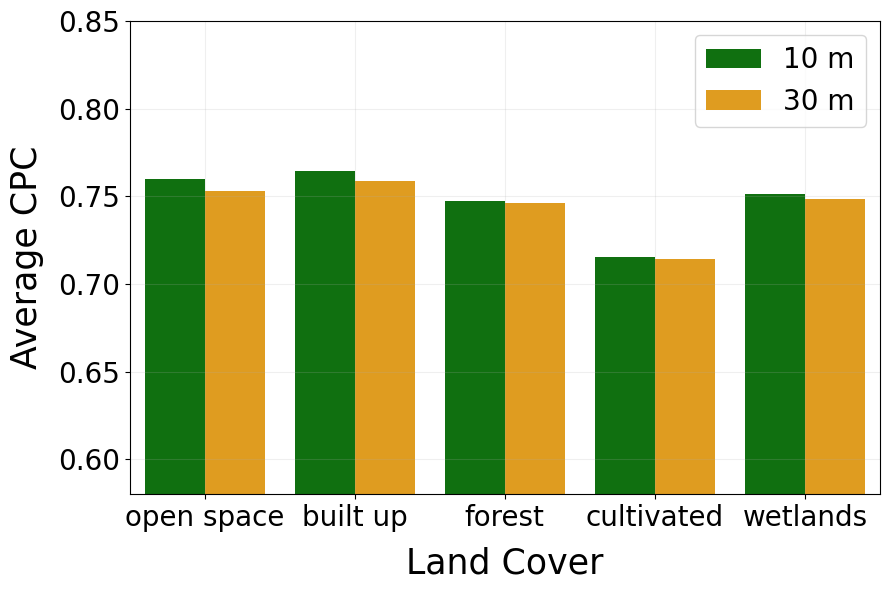

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json

column_name = 'LC'
axisx_label = 'Land Cover'
# x_ticklabels = ['built up', 'forest','cultivated', 'wetlands', 'water', 'open space']
x_ticklabels = ['open space', 'built up', 'forest', 'cultivated', 'wetlands']
df = home_sum
x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

# st = fig.suptitle(country_to_string[country], fontsize=30)

# avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
# std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []

table = pd.DataFrame(columns=['decile','count',
                            #   'CPC r1w mean',
                                'CPC s2 mean','CPC l8 mean'])
# for decile in sorted(df[column_name].unique()):
for decile in ['VALUE_21', 'SUM_22_23_24', 'SUM_4', 'SUM_8', 'SUM_9']:
    df_temp = df[df[column_name] == decile]

    # avg_r1w = df_temp.h_cpc_r1w.mean()
    avg_s2 = df_temp.h_cpc_s2.mean()
    avg_l8 = df_temp.h_cpc_l8.mean()
    

    # avg_r1ws.append(avg_r1w)
    avg_s2s.append(avg_s2)
    avg_l8s.append(avg_l8)

    # std_r1w = df_temp.h_cpc_r1w.std()
    std_s2 = df_temp.h_cpc_s2.std()
    std_l8 = df_temp.h_cpc_l8.std()

    # std_r1ws.append(std_r1w)
    std_s2s.append(std_s2)
    std_l8s.append(std_l8)

    table = table.append({'decile':decile,
                'count':len(df_temp),
            #    'CPC r1w mean':avg_r1w,
                'CPC s2 mean':avg_s2,
                'CPC l8 mean':avg_l8}
                ,ignore_index=True)

print(table)


table_s2 = table[['decile', 'count', 'CPC s2 mean']].rename(columns={'CPC s2 mean':'mean_cpc'})
table_s2['resolution'] = '10 m'
table_l8 = table[['decile', 'count', 'CPC l8 mean']].rename(columns={'CPC l8 mean':'mean_cpc'})
table_l8['resolution'] = '30 m'
table_2 = pd.concat([table_s2, table_l8])

sns.barplot(table_2, x="decile", y="mean_cpc", hue="resolution", palette=['green', 'orange'])

# ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
#           color='darkgrey', linewidth=2, 
#           label='MFG', markersize=8)

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0.58,0.85)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='upper right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig('./figs/M1_LC.png')

# Population

In [5]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
sorted(home_sum.LU.unique())
home_sum = pd.read_csv('M1band3_M1_home_decile_cpc_sub512.csv', index_col=0)#_#layers1_emb128_developed_25.csv')
sorted(home_sum.LU.unique())

In [66]:
def plot_decile(df, column_name, axisx_label,x_ticklabels, x_ticks,savename):
   fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharex=True)
   avg_r1ws,avg_s2s,avg_l8s = [], [], []
   std_r1ws,std_s2s,std_l8s = [], [], []

   table = pd.DataFrame(columns=['decile','count',
                              #   'CPC r1w mean',
                                 'CPC s2 mean','CPC l8 mean'])
   for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      # avg_r1w = df_temp.h_cpc_r1w.mean()
      avg_s2 = df_temp.h_cpc_s2.mean()
      avg_l8 = df_temp.h_cpc_l8.mean()
      

      # avg_r1ws.append(avg_r1w)
      avg_s2s.append(avg_s2)
      avg_l8s.append(avg_l8)

      # std_r1w = df_temp.h_cpc_r1w.std()
      std_s2 = df_temp.h_cpc_s2.std()
      std_l8 = df_temp.h_cpc_l8.std()

      # std_r1ws.append(std_r1w)
      std_s2s.append(std_s2)
      std_l8s.append(std_l8)

      table = table.append({'decile':decile,
                  'count':len(df_temp),
               #    'CPC r1w mean':avg_r1w,
                  'CPC s2 mean':avg_s2,
                  'CPC l8 mean':avg_l8}
                  ,ignore_index=True)

   print(table)

   # decile plots
   ax = axes

   ax.errorbar(range(x_ticks), avg_s2s, yerr=std_s2s, marker='v',
            color='green', label='10 m', linewidth=1, markersize=10, zorder=3)  

   ax.errorbar(range(x_ticks), avg_l8s, yerr=std_l8s,
            color='orange', label='30 m', linestyle='--', linewidth=3)  


   ax.set_ylabel('Average CPC', fontsize=25)
   ax.set_xlabel(axisx_label, fontsize=25)
   ax.set_xticks(range(x_ticks))
   ax.set_xticklabels(x_ticklabels)
   ax.set_ylim(-0.05,1)
   ax.tick_params(labelsize=20)
   ax.grid(alpha=0.2)
   # ax.set_title(country_to_subid[country][0], fontsize=30)
   ax.legend(fontsize=20, loc='lower right')



   plt.subplots_adjust(wspace=0.3)
   #fig.suptitle(country2long_name[country], fontsize=20)
   plt.tight_layout()
   plt.savefig(savename)

   decile  count  CPC s2 mean  CPC l8 mean
0     1.0  479.0     0.737229     0.732476
1     2.0  478.0     0.750951     0.745774
2     3.0  478.0     0.758513     0.752711
3     4.0  478.0     0.763205     0.757313
4     5.0  478.0     0.765611     0.760681
5     6.0  479.0     0.768975     0.762769
6     7.0  479.0     0.771729     0.763394
7     8.0  477.0     0.768013     0.763290
8     9.0  481.0     0.775696     0.771777
9    10.0  479.0     0.759368     0.756144


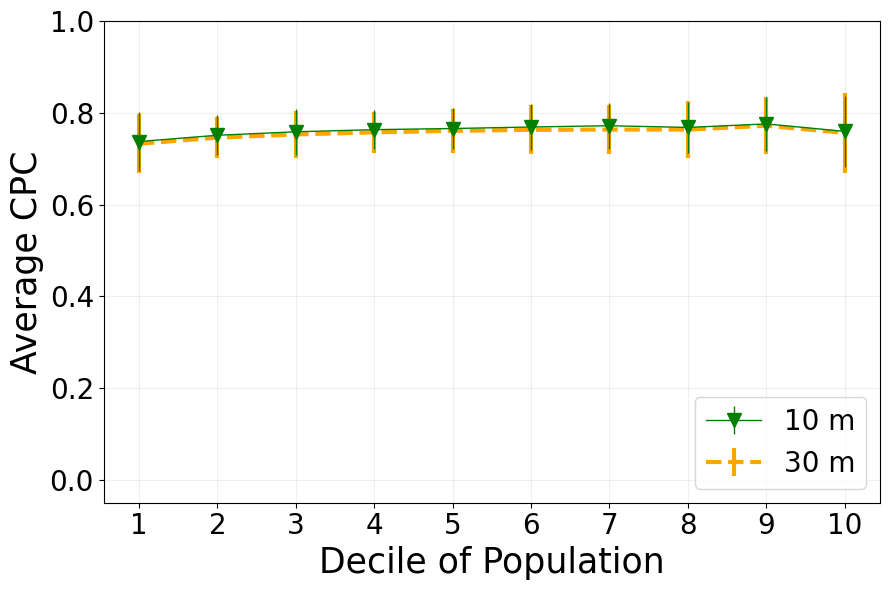

In [67]:
plot_decile(home_sum, 'decile', 'Decile of Population', range(1,11), 10, './figs/M1_Population.png')

# Flow Distance

In [2]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

feat = gpd.read_file('data/M1_NYCensusTractstl_2020_tract20_M1.shp')
feat['centroid_x'] = feat['geometry'].centroid.x
feat['centroid_y'] = feat['geometry'].centroid.y
res_total = pd.merge(left=res_total, right=feat, left_on='h_geocode', right_on='GEOID20')[['w_geocode', 'h_geocode', 'count','prediction_s2','prediction_l8', 'centroid_x', 'centroid_y']]
res_total = res_total.rename(columns={'centroid_x': "h_centroid_x", 'centroid_y':'h_centroid_y'})
res_total = pd.merge(left=res_total, right=feat, left_on='w_geocode', right_on='GEOID20')[['w_geocode', 'h_geocode', 'count','prediction_s2','prediction_l8','h_centroid_x', 'h_centroid_y', 'centroid_x', 'centroid_y']]
res_total = res_total.rename(columns={'centroid_x': "w_centroid_x", 'centroid_y':'w_centroid_y'})
res_total.to_csv('flows_M1_2020_xy.csv')
# res_total

c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [8]:
# 计算距离
from shapely.geometry import Point
import geopy.distance

def haversine(o_x, o_y, d_x, d_y):
    distance = geopy.distance.distance((o_y, o_x), (d_y, d_x)).m

    return distance


In [9]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)
res_total['distance'] = res_total.progress_apply(lambda row: haversine(row['h_centroid_x'], row['h_centroid_y'], row['w_centroid_x'], row['w_centroid_y']), axis=1)
res_total['common_s2'] = res_total[['prediction_s2','count']].min(axis=1)
res_total['common_l8'] = res_total[['prediction_l8','count']].min(axis=1)

import jenkspy

breaks = jenkspy.jenks_breaks(res_total['distance'], n_classes=5)
res_total['cut_jenks'] = pd.cut(res_total['distance'],
                        bins=breaks,
                        labels=['d1', 'd2', 'd3', 'd4', 'd5'],include_lowest=True)
res_total['f_cpc_s2'] = 2* res_total['common_s2'] / (res_total['count']+res_total['prediction_s2'])
res_total['f_cpc_l8'] = 2* res_total['common_l8'] / (res_total['count']+res_total['prediction_l8'])
res_total_dis = res_total.groupby('cut_jenks').sum()
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
res_total_dis['cpc_s2'] = 2 * res_total_dis['common_s2'] / (res_total_dis['count']+res_total_dis['prediction_s2'])
res_total_dis['cpc_l8'] = 2 * res_total_dis['common_l8'] / (res_total_dis['count']+res_total_dis['prediction_l8'])


  0%|                  | 0/120559 [00:00<?, ?it/s]

100%|███| 120559/120559 [00:49<00:00, 2447.38it/s]


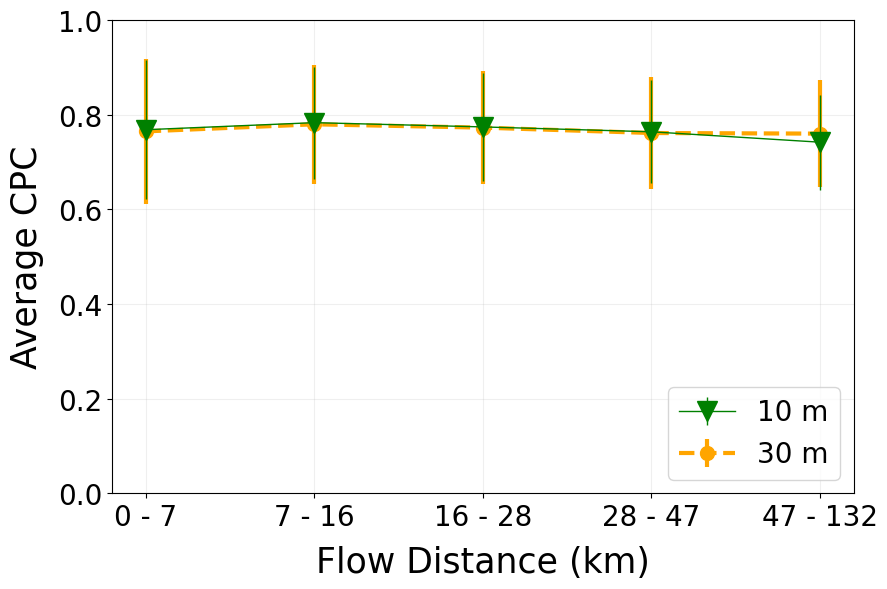

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns


column_name = 'cut_jenks'
axisx_label = 'Flow Distance (km)'
# [0.0, 6841.707559636252, 15961.059075733567, 29481.087492216324, 52608.85742812191, 171166.29727487377]
x_ticklabels = [ '0 - 7','7 - 16', '16 - 28', '28 - 47', '47 - 132']

x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)
df = res_total
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []
for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      # avg_r1w = df_temp.h_cpc_r1w.mean()
      avg_s2 = df_temp.f_cpc_s2.mean()
      avg_l8 = df_temp.f_cpc_l8.mean()
      

      # avg_r1ws.append(avg_r1w)
      avg_s2s.append(avg_s2)
      avg_l8s.append(avg_l8)

      # std_r1w = df_temp.h_cpc_r1w.std()
      std_s2 = df_temp.f_cpc_s2.std()
      std_l8 = df_temp.f_cpc_l8.std()

      # std_r1ws.append(std_r1w)
      std_s2s.append(std_s2)
      std_l8s.append(std_l8)


ax.errorbar(range(x_ticks), avg_s2s, yerr=std_s2s, marker='v',
         color='green', label='10 m', linewidth=1, markersize=15, zorder=3)  

ax.errorbar(range(x_ticks), avg_l8s, yerr=std_l8s, marker='o',markersize=10,
         color='orange', label='30 m', linestyle='--', linewidth=3)  

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='lower right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig('./figs/M1_flowdis.png')

# Flow Volume / Intensity

In [39]:
breaks_i = jenkspy.jenks_breaks(res_total['count'], n_classes=5)
print(breaks_i)
res_total['cut_jenks_intensity'] = pd.cut(res_total['count'],
                        bins=breaks_i,
                        labels=['c1', 'c2', 'c3', 'c4', 'c5'],include_lowest=True)
res_total_intensity = res_total.groupby('cut_jenks_intensity').sum()
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
res_total_intensity['cpc_s2'] = 2 * res_total_intensity['common_s2'] / (res_total_intensity['count']+res_total_intensity['prediction_s2'])
res_total_intensity['cpc_l8'] = 2 * res_total_intensity['common_l8'] / (res_total_intensity['count']+res_total_intensity['prediction_l8'])
res_total_intensity

[11.0, 23.0, 47.0, 94.0, 231.0, 861.0]


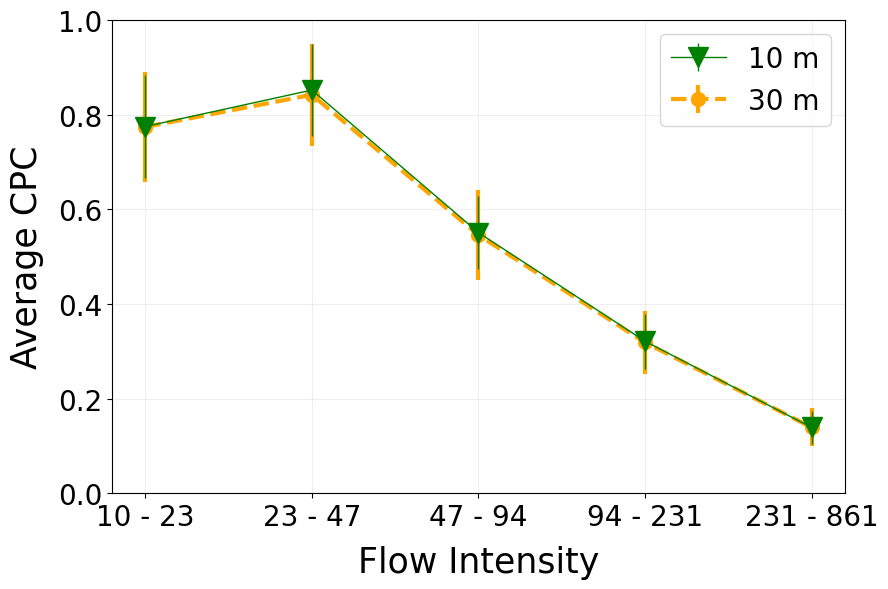

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns


column_name = 'cut_jenks_intensity'
axisx_label = 'Flow Intensity'
# [11.0, 23.0, 47.0, 94.0, 231.0, 861.0]
x_ticklabels = [ '10 - 23','23 - 47', '47 - 94', '94 - 231', '231 - 861']

x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)
df = res_total
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []
for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      # avg_r1w = df_temp.h_cpc_r1w.mean()
      avg_s2 = df_temp.f_cpc_s2.mean()
      avg_l8 = df_temp.f_cpc_l8.mean()
      

      # avg_r1ws.append(avg_r1w)
      avg_s2s.append(avg_s2)
      avg_l8s.append(avg_l8)

      # std_r1w = df_temp.h_cpc_r1w.std()
      std_s2 = df_temp.f_cpc_s2.std()
      std_l8 = df_temp.f_cpc_l8.std()

      # std_r1ws.append(std_r1w)
      std_s2s.append(std_s2)
      std_l8s.append(std_l8)

      table = table.append({'decile':decile,
                  'count':len(df_temp),
               #    'CPC r1w mean':avg_r1w,
                  'CPC s2 mean':avg_s2,
                  'CPC l8 mean':avg_l8}
                  ,ignore_index=True)

ax.errorbar(range(x_ticks), avg_s2s, yerr=std_s2s, marker='v',
         color='green', label='10 m', linewidth=1, markersize=15, zorder=3)  

ax.errorbar(range(x_ticks), avg_l8s, yerr=std_l8s, marker='o',markersize=10,
         color='orange', label='30 m', linestyle='--', linewidth=3)  

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='upper right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig('./figs/M1_flowIntensity.png')

# Distance Distribution and Urban Form

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui

res_total = pd.read_csv('flows_M1_2020_xy.csv',  index_col=0)

tqdm.pandas(ncols=50)
res_total['distance'] = res_total.progress_apply(lambda row: haversine(row['h_centroid_x'], row['h_centroid_y'], row['w_centroid_x'], row['w_centroid_y']), axis=1)

res_total.to_csv('flows_M1_2020_xyd.csv')

In [3]:
import powerlaw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
from scipy.stats import linregress
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr
from scipy.stats import entropy
from tqdm import tqdm

Mx = 'M1'
global cities
cities = ["New York", "Los Angeles", "Chicago", "Dallas", "Houston"
          , "D.C.", "Philadelphia", "Miami", "Atlanta", "Phoenix" ]

def exponential_alpha(Mx, xmin):
    res_total = pd.read_csv('../../flows_xyd/flows_{}_2020_xyd.csv'.format(Mx),  index_col=0)
    res_total = res_total[res_total['distance'].apply(lambda x: round(x/1000))!=0]

    delta_v = res_total[['count', 'prediction_s2', 'prediction_l8', 'distance']]
    delta_v['prediction_s2'] = delta_v['prediction_s2'].apply(lambda x:round(x))
    delta_v['prediction_l8'] = delta_v['prediction_l8'].apply(lambda x:round(x))

    delta_v_density = delta_v.copy()
    delta_v_density['distance'] = delta_v_density['distance'].apply(lambda x: round(x/1000)) # km
    delta_v_density = delta_v_density.groupby(['distance']).sum().reset_index()
    delta_v_density = delta_v_density.sort_values(by='distance')

    delta_v_count = delta_v_density.copy()
    delta_v_count['pdf'] = delta_v_count['count'] / delta_v_count['count'].sum()

    delta_v_s2 = delta_v_density.copy()
    delta_v_s2['pdf'] = delta_v_s2['prediction_s2'] / delta_v_s2['prediction_s2'].sum()

    delta_v_l8 = delta_v_density.copy()
    delta_v_l8['pdf'] = delta_v_l8['prediction_l8'] / delta_v_l8['prediction_l8'].sum()

    
    data = np.repeat(delta_v_count['distance'], delta_v_count['count'])

    fit2 = powerlaw.Fit(data,xmin=xmin)
    alpha = fit2.exponential.parameter1
    xmin = fit2.exponential.xmin
    # lambda_ = fit2.exponential.parameter2
    print(f"Alpha: {alpha}, Xmin: {xmin}, D: {fit2.exponential.D}")

    p = plt.figure(figsize=(6, 6))
    fig = p.add_subplot(111)
    fit2.exponential.plot_pdf(color='r', label=f'$\lambda = {alpha:.3f}$', ax=fig)
    fig.set_title(Mx+" "+cities[int(Mx.replace('M', ''))-1], fontsize=18)
    fig.set_xlabel('$d (km)$', fontsize=18)
    fig.set_ylabel('$P(d)$', fontsize=18)   
    fig.tick_params(labelsize=12)
    fig.set_ylim(ymin = 10**-5.6, ymax = 10**-0.6)
    fig.set_xlim(xmin = 10**-0.1, xmax = 10**2.3)
    fig.minorticks_on()
    delta_v_count['pdf'] = delta_v_count['count'] / delta_v_count['count'].sum()
    fig.scatter(delta_v_count['distance'], delta_v_count['pdf'], marker='o', color='b', label=f'Empirical observation')
    fig.scatter(delta_v_s2['distance'], delta_v_s2['pdf'], marker='s', color='g', label=f'Prediction (10-m)')
    fig.scatter(delta_v_l8['distance'], delta_v_l8['pdf'], marker='^', color='yellow', label=f'Prediction (30-m)')
    plt.legend(loc='lower left')
    plt.savefig("data/Exponential_distribution_M10_powerlawpkg/{}_exponential.png".format(Mx),dpi = 300,bbox_inches='tight')
    plt.show()
    
    W1, W2, W3 = compare(fit2, data)
    return alpha, xmin, fit2.exponential.D, W1, W2, W3
    # KS_stat(fit2, 2500, len(data))



def compare(fit, data):
    R, p = fit.distribution_compare('power_law', 'truncated_power_law', normalized_ratio = True) #truncated_power_law
    print (R, p)
    R, p = fit.distribution_compare('exponential', 'power_law', normalized_ratio = True) #exponential
    print (R, p)
    R, p = fit.distribution_compare('exponential', 'truncated_power_law', normalized_ratio = True) #truncated_power_law
    print (R, p)
    # Get the log-likelihood for each distribution
    loglik_powerlaw = np.sum(fit.power_law.loglikelihoods(data))
    loglik_exponential = np.sum(fit.exponential.loglikelihoods(data))
    loglik_truncated_powerlaw = np.sum(fit.truncated_power_law.loglikelihoods(data))

    k_powerlaw = 1
    k_exponential = 1
    k_truncated_powerlaw = 2

    # Calculate AIC for each distribution
    aic_powerlaw = 2 * k_powerlaw - 2 * loglik_powerlaw
    aic_exponential = 2 * k_exponential - 2 * loglik_exponential
    aic_truncated_powerlaw = 2 * k_truncated_powerlaw - 2 * loglik_truncated_powerlaw

    print(f"AIC for power law: {aic_powerlaw}")
    print(f"AIC for exponential: {aic_exponential}")
    print(f"AIC for truncated power law: {aic_truncated_powerlaw}")

    aic_min = min(aic_powerlaw,aic_exponential,aic_truncated_powerlaw)
    delta_1 = aic_powerlaw - aic_min
    delta_2 = aic_exponential - aic_min
    delta_3 = aic_truncated_powerlaw - aic_min 
    sum_w = np.exp( - delta_1 / 2) + np.exp( - delta_2 / 2) + np.exp( - delta_3 / 2) 
    W_1 = np.exp( - delta_1 / 2) / sum_w
    W_2 = np.exp( - delta_2 / 2) / sum_w
    W_3 = np.exp( - delta_3 / 2) / sum_w
    print("%.4f  "%W_1, "%.4f  "%W_2,"%.4f"%W_3)

    return W_1, W_2, W_3

def KS_stat(fit, num_synthetic_datasets,data_len):
    ks_stat_empirical = fit.exponential.D
    # Array to store the KS statistics for the synthetic datasets
    ks_stats_synthetic = []

    # Generate synthetic data sets and calculate the KS statistic for each
    for _ in tqdm(range(num_synthetic_datasets)):
        synthetic_data = fit.exponential.generate_random(data_len)
        fit_synthetic = powerlaw.Fit(synthetic_data, xmin=1)
        ks_stat_synthetic = fit_synthetic.exponential.D
        ks_stats_synthetic.append(ks_stat_synthetic)

    # Calculate the p-value
    ks_stats_synthetic = np.array(ks_stats_synthetic)
    p_value = np.sum(ks_stats_synthetic > ks_stat_empirical) / num_synthetic_datasets

    print(f"KS statistic for empirical data: {ks_stat_empirical}")
    print(f"p-value: {p_value}")

    # Plot the KS statistics for the synthetic datasets
    plt.hist(ks_stats_synthetic, bins=50, density=True, alpha=0.6, color='gray', label='KS stats for synthetic datasets')
    plt.axvline(ks_stat_empirical, color='r', linestyle='--', label='KS stat for empirical data')
    plt.xlabel('KS Statistic')
    plt.ylabel('Density')
    plt.title('KS Statistics for Synthetic Data Sets')
    plt.legend()
    plt.show()

# i=1
# exponential_alpha("M{}".format(i),1)

c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.10626082290045422, Xmin: 1.0, D: 0.044686401231082085


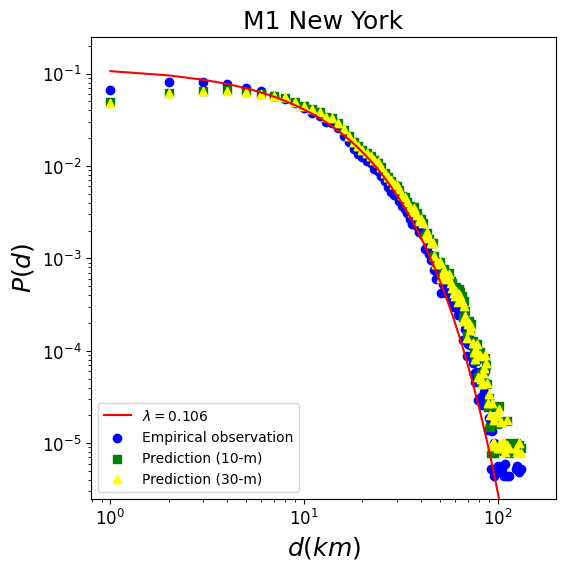

Assuming nested distributions


-1605.7198280293862 0.0000
785.2869955251218 0.0000
333.64678755651346 0.0000
AIC for power law: 18013066.36723127
AIC for exponential: 16149489.672556352
AIC for truncated power law: 16665405.211910032
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.0880362990162496, Xmin: 1.0, D: 0.0786402124372062


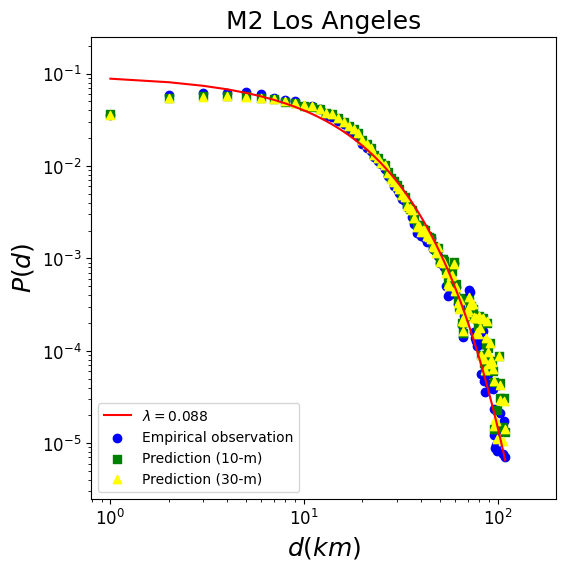

Assuming nested distributions


-1796.801263432738 0.0000
934.3664131980177 0.0000
512.5959796886381 0.0000
AIC for power law: 12328447.6633478
AIC for exponential: 10728802.812252915
AIC for truncated power law: 11322488.913301943
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.07221920803252216, Xmin: 1.0, D: 0.0587929600726714


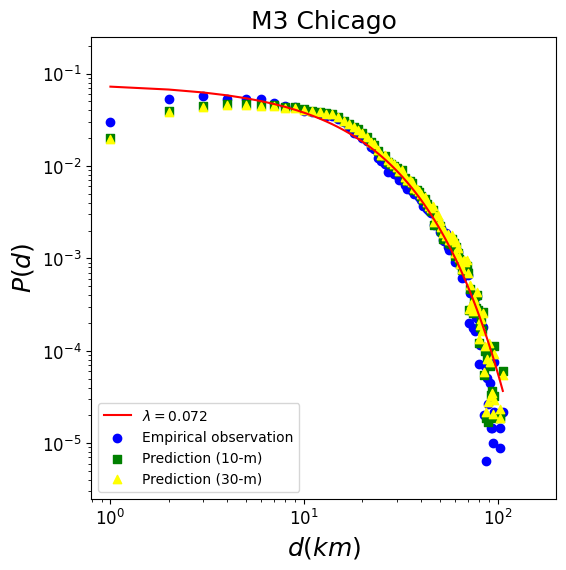

Assuming nested distributions


-1980.820000954384 0.0000
997.8258810500637 0.0000
540.7428845272133 0.0000
AIC for power law: 14138445.944355661
AIC for exponential: 12329643.379674433
AIC for truncated power law: 13003587.085229043
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.06155790114446888, Xmin: 1.0, D: 0.10462678552276608


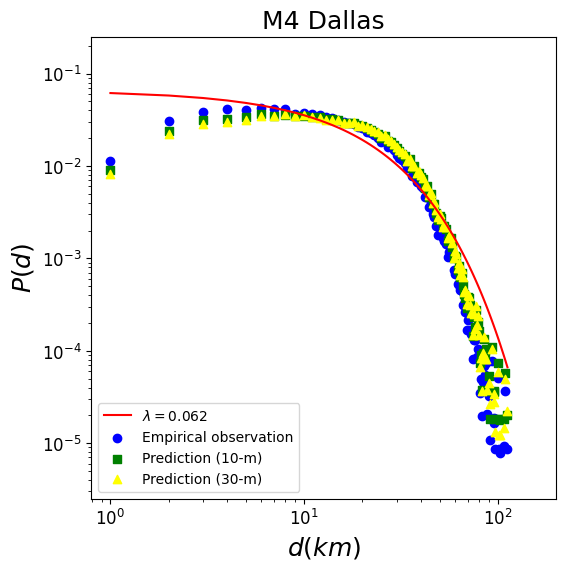

Assuming nested distributions


-2632.214537257234 0.0000
1413.0617591235534 0.0000
898.6512482755826 0.0000
AIC for power law: 12472448.31555437
AIC for exponential: 10517237.10372636
AIC for truncated power law: 11394647.504281363
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.06067888160434037, Xmin: 1.0, D: 0.09222418578686903


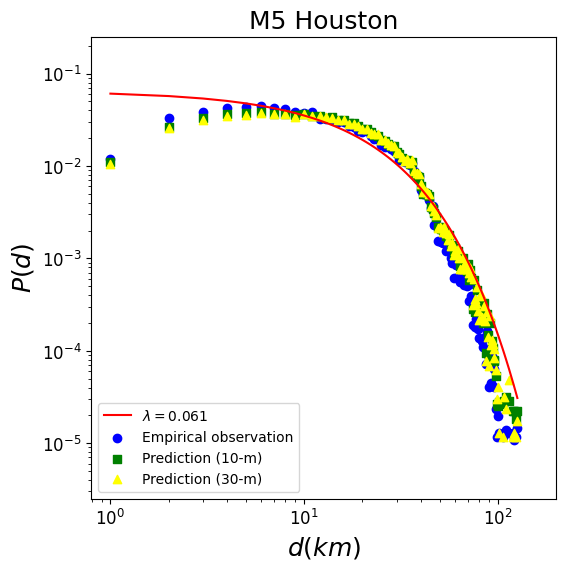

Assuming nested distributions


-2153.967353166418 0.0000
1139.0193436954517 0.0000
709.6338692546738 0.0000
AIC for power law: 9144424.439987876
AIC for exponential: 7753231.439437434
AIC for truncated power law: 8364805.671558189
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.07499024024430281, Xmin: 1.0, D: 0.08016089123098186


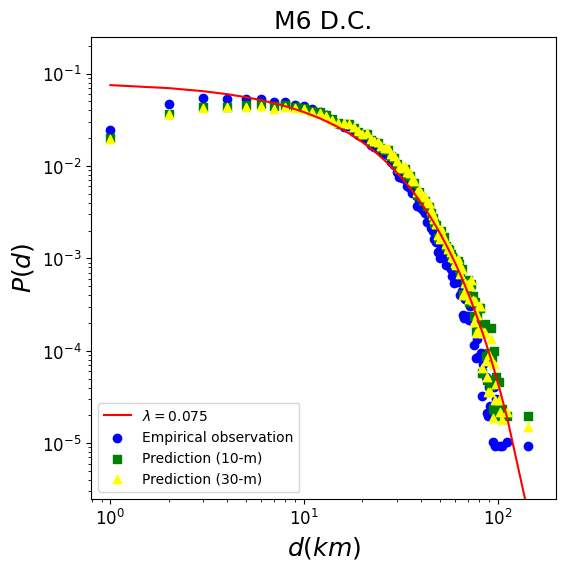

Assuming nested distributions


-1828.688420061449 0.0000
960.4411990138664 0.0000
558.4546577408097 0.0000
AIC for power law: 9777380.524273066
AIC for exponential: 8423757.606445827
AIC for truncated power law: 8964870.43160705
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.09936841445374496, Xmin: 1.0, D: 0.09206254662455465


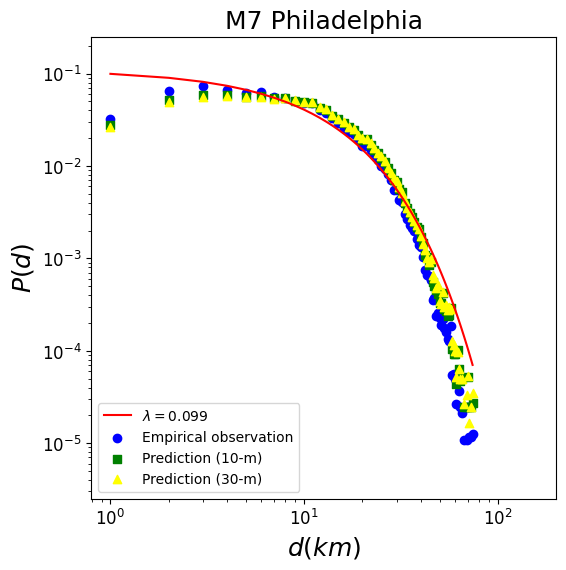

Assuming nested distributions


-1562.1467311115816 0.0000
868.0914063511559 0.0000
509.4988533475001 0.0000
AIC for power law: 7865843.477307227
AIC for exponential: 6778055.395313503
AIC for truncated power law: 7201063.213426322
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.08306252277069986, Xmin: 1.0, D: 0.10715512830889379


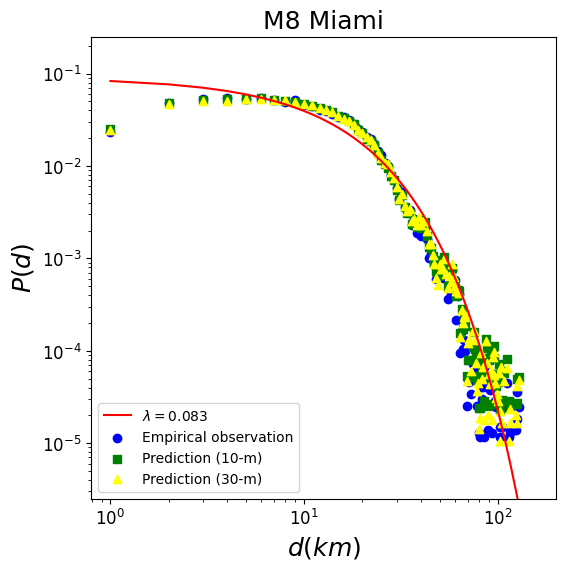

Assuming nested distributions


-1723.2544972498465 0.0000
938.7997747185319 0.0000
572.1299806835582 0.0000
AIC for power law: 7703580.101058233
AIC for exponential: 6567048.254049699
AIC for truncated power law: 7041238.9593882505
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.06237078272436292, Xmin: 1.0, D: 0.11012588152332559


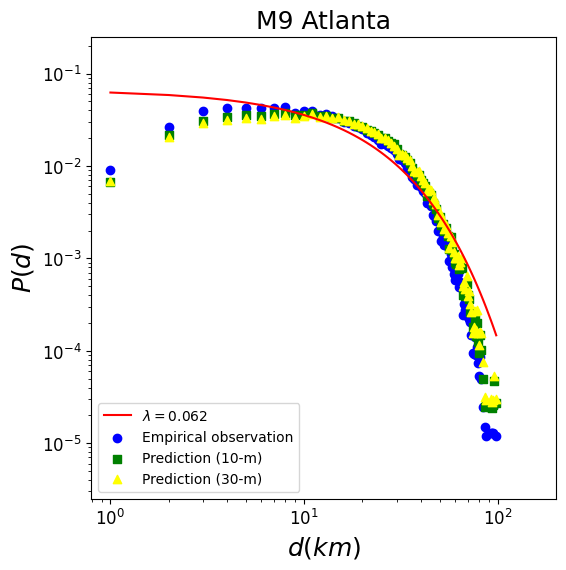

Assuming nested distributions


-2262.6440589959675 0.0000
1223.7279126003048 0.0000
784.4679530919665 0.0000
AIC for power law: 8305279.458410628
AIC for exponential: 6987209.7874413775
AIC for truncated power law: 7583168.383077563
0.0000   1.0000   0.0000


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Alpha: 0.05803971603134632, Xmin: 1.0, D: 0.10936807886177596


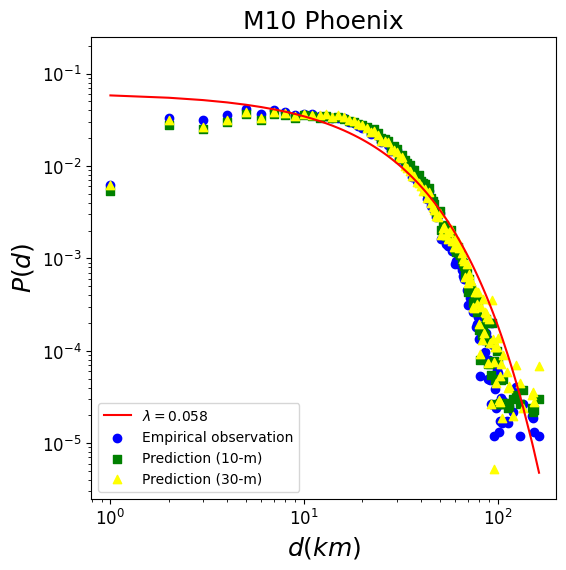

Assuming nested distributions


-2263.6336194924806 0.0000
1204.8593740689612 0.0000
770.7029685001182 0.0000
AIC for power law: 8326229.715437345
AIC for exponential: 7003551.189964695
AIC for truncated power law: 7605813.506503104
0.0000   1.0000   0.0000


In [4]:
table_alpha_exp = pd.DataFrame(columns=['Metro','alpha', 'xmin', 'D', 'W1', 'W2', 'W3'])

for i in range(1,11):
    e1, e3,e4, w1, w2, w3 = exponential_alpha("M{}".format(i),1)
    table_alpha_exp = table_alpha_exp.append({'Metro':"M{}".format(i),
                'alpha':e1,
                'xmin':e3,
                'D':e4,
                'W1':w1,
                'W2':w2,
                'W3':w3,
                }
                ,ignore_index=True)

In [5]:
import geopandas as gpd
bci = gpd.read_file("data、bci_ExportFeatures.dbf")
table_alpha_exp = pd.merge(left=table_alpha_exp, right=bci, on='Metro')
table_alpha_exp = table_alpha_exp.drop(columns="geometry")
table_alpha_exp = table_alpha_exp.assign(popden=[607.037214, 710.764124, 215.110059, 230.406186, 240.424770,
                              222.175791, 298.546516, 347.597264, 183.739489, 89.504215
])
table_alpha_exp = table_alpha_exp.assign(polycentric=[-1.65, -1.433,-1.653, -1.835, -1.755, -1.777, -1.569, -1.65, -1.708, -1.847
])

In [6]:
from matplotlib.ticker import MaxNLocator
from scipy import stats

def scatter2d_y_exponent_label(df, x_label, x_label_name):
    fig, axes = plt.subplots(1, 1,figsize=(8, 8))
    # ax = fig.add_subplot(11)
    # Fit a linear model to the log-transformed data
    slope, intercept, r_value, p_value, std_err = linregress(df[x_label], df['alpha'])
    correlation = np.corrcoef(df['alpha'], intercept + slope * df[x_label])[0,1]  #相关系数
    R2 = correlation**2 
    plt.plot(df[x_label], intercept + slope * df[x_label], color='red', label=f'Fitted line: y = {intercept:.2f} + {slope:.2f}x \n R^2 = {R2:.2f}')

    # Scatter plot
    scatter = plt.scatter(df[x_label], df['alpha'], c='b', marker='o', s=50)

    # Adding labels
    for i, txt in enumerate(df['Metro']):
        plt.text(df[x_label][i], df['alpha'][i], txt, fontsize=12)

    # Setting labels
    axes.xaxis.set_major_locator(MaxNLocator(6))
    plt.xlabel(x_label_name, fontsize=18)
    plt.ylabel('$\lambda$', fontsize=18)
    plt.tick_params(labelsize=12)
    print(stats.pearsonr(df[x_label],df['alpha']))

    plt.text(0.1,0.93,"r = %.2f (p < 0.05)"%(stats.pearsonr(df[x_label],df['alpha'])[0]), transform = axes.transAxes, fontsize=12)

    fig.savefig('/data/Exponential_distribution_M10_powerlawpkg/{}_lambda.jpg'.format(x_label),bbox_inches='tight',ddip=300)
    plt.show()

(0.6724645840594266, 0.03313558837565051)


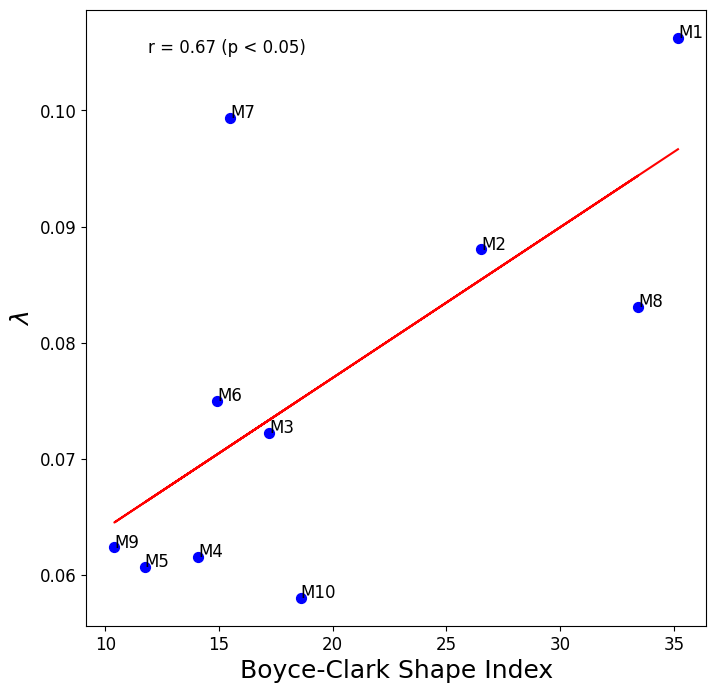

(0.7385347444507151, 0.014704547063004048)


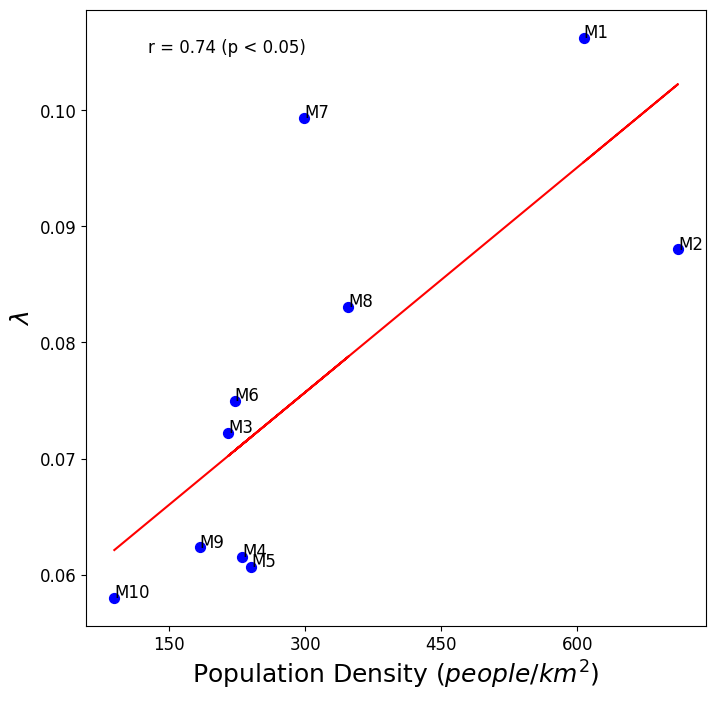

(0.6976576606720677, 0.024892606154907657)


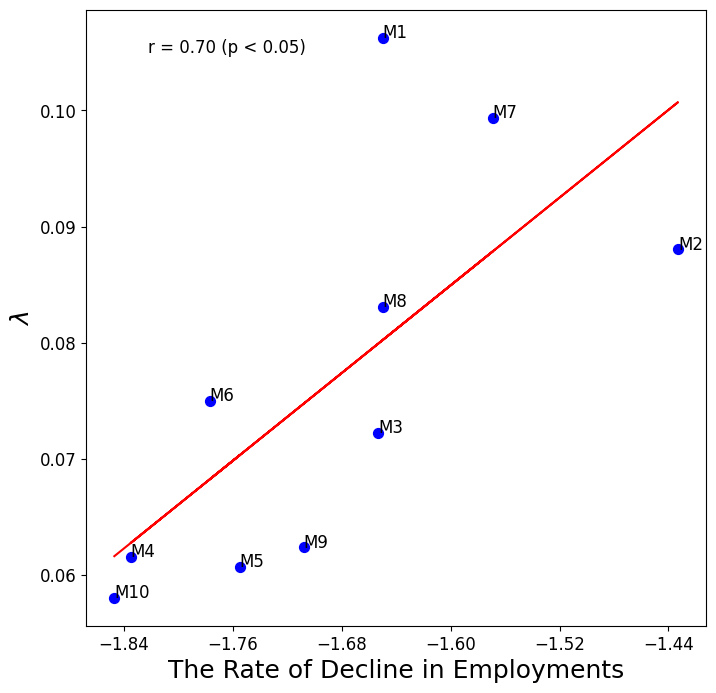

In [7]:
scatter2d_y_exponent_label(table_alpha_exp, 'bci', 'Boyce-Clark Shape Index') # R^2 = 0.45   (0.6724645840594267, 0.03313558837565047)
scatter2d_y_exponent_label(table_alpha_exp, 'popden', 'Population Density (${people / km^2}$)') # R^2 = 0.55    (0.7385347444507155, 0.014704547063003958)
scatter2d_y_exponent_label(table_alpha_exp, 'polycentric', 'The Rate of Decline in Employments') # R^2 = 0.49    (0.6976576606720677, 0.024892606154907657)

# Employments

In [2]:
import pandas as pd 
import numpy as np
import os

job_table = pd.DataFrame(columns=['w_geocode','job_sum', 'rank', 'log_rank', 'log_job', 'metro'])

In [3]:
import pandas as pd 
import numpy as np
import os

for i in range(1, 11):
    path = '/Data'
    flows_m1_10 = pd.read_csv(os.path.join(path, 'CommutingFlow_M{}_2020gt10.csv'.format(i)),
                        dtype={'h_geocode': str,'w_geocode': str})
    work_m1 = flows_m1_10[['w_geocode','count']].groupby('w_geocode').sum()
    work_m1 = work_m1.rename(columns={'count':'job_sum'})
    work_m1['rank'] = work_m1['job_sum'].rank(ascending=False)
    work_m1['log_rank'] = work_m1['rank'].apply(lambda x: np.log10(x))
    work_m1['log_job'] = work_m1['job_sum'].apply(lambda x: np.log10(x))
    work_m1['metro'] = 'M{}'.format(i)
    job_table = job_table.append(work_m1.reset_index()
                    ,ignore_index=True)

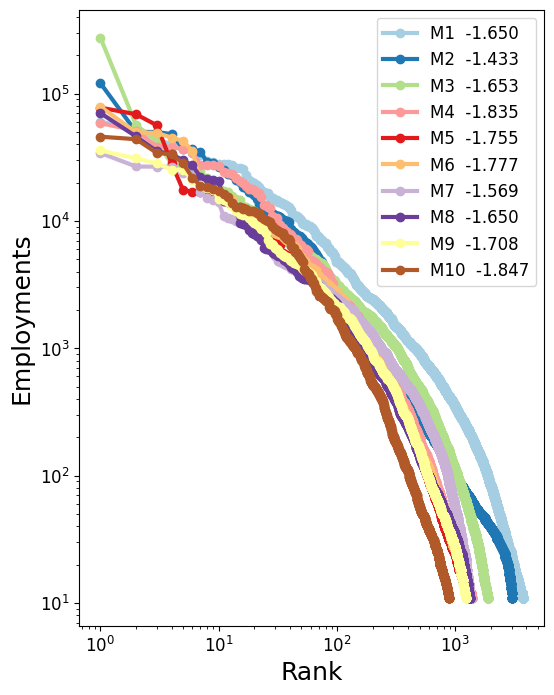

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText

import numpy as np
import pandas as pd
import os

colormap = plt.cm.Paired #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,10)]

slope_list, intercept_list = np.array([]),np.array([])

for i in range(1,11):
    metro = 'M{}'.format(i)
    slope, intercept = np.polyfit(job_table[job_table['metro']==metro]['log_rank'], job_table[job_table['metro']==metro]['log_job'], 1)
    slope_list = np.append(slope_list, slope)
    intercept_list = np.append(intercept_list, intercept)
slope_list = np.around(slope_list, decimals=3)

f, ax = plt.subplots(1, 1, figsize=(6,8))

for i in range(1,11):
    m1 = job_table[job_table['metro']=='M{}'.format(i)].sort_values(by='job_sum').copy()
    plt.plot(m1['rank'], m1['job_sum'],label='M{}  '.format(i) + str("%.3f"%slope_list[i-1]), linewidth=3, color= colors[i-1], marker='o', markerfacecolor=colors[i-1])

ax.set_xscale("log", base=10); ax.set_yscale("log", base=10)
ax.set_ylabel("Employments", fontsize = 18)
ax.tick_params(labelsize=12)
ax.set_xlabel("Rank", fontsize = 18)
ax.legend(fontsize=12, loc='upper right')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
f.savefig('job_rank_loglog10.jpg',dpi=300,bbox_inches='tight')